<a href="https://colab.research.google.com/github/MarigoldJ/ygl2/blob/main/class/20210625_nlp_day9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BILSTM + CRF 개체명 인식

[참고링크 - 위키독스](https://wikidocs.net/34156)

In [1]:
# ! pip install tensorflow==1.14.0
! pip install keras==2.2.4
# ! pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 317kB 8.4MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-rnclefo9
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-rnclefo9
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101078 sha256=0c791aef4c94134434c4280c61cfae4c6e7660a07f74dd95181bfaf97f500f50
  Stored in directory: /tmp/pip-ephem-wheel-cache-ln0ztm_c/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [4]:
! wget -NP ./ https://raw.githubusercontent.com/MarigoldJ/ygl2/main/%ED%95%99%EC%8A%B5%EC%9E%90%EB%A3%8C/NLP/dataset/ner_dataset.csv

path_to_file_kaggle = './ner_dataset.csv'

--2021-06-25 02:57:38--  https://raw.githubusercontent.com/MarigoldJ/ygl2/main/%ED%95%99%EC%8A%B5%EC%9E%90%EB%A3%8C/NLP/dataset/ner_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14159575 (14M) [text/plain]
Saving to: ‘./ner_dataset.csv’

ner_dataset.csv     100%[===================>]  13.50M  40.5MB/s    in 0.3s    

Last-modified header missing -- time-stamps turned off.
2021-06-25 02:57:39 (40.5 MB/s) - ‘./ner_dataset.csv’ saved [14159575/14159575]



In [5]:
# 캐글데이터 불러오기
data = pd.read_csv(path_to_file_kaggle, encoding='latin1')
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [6]:
# 데이터 확인해보기
print('데이터 행 개수 :', len(data))
print('데이터 null값이 있는가? :', data.isnull().values.any())

데이터 행 개수 : 1048575
데이터 null값이 있는가? : True


In [7]:
print('Sentence # 열의 중복을 제거한 값의 개수 :', data['Sentence #'].nunique())    # 문장 개수
print('Word 열의 중복을 제거한 값의 개수 :', data['Word'].nunique())                # 단어 가짓수
print('Tag 열의 중복을 제거한 값의 개수 :', data['Tag'].nunique())                  # 태그 가짓수

Sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [8]:
print('Tag 열의 각 값의 개수')
print('='*30)
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각 값의 개수
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [9]:
# null값 제거
data = data.fillna(method='ffill')  # front fill
data.tail()

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [10]:
# null 값 제거가 잘 되었는지 확인
print('데이터 null값이 있는가? :', data.isnull().values.any())

데이터 null값이 있는가? : False


In [11]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 :', data['Word'].nunique())    # 단어 가짓수
print()
data.head()

Word 열의 중복을 제거한 값의 개수 : 31817



,Sentence #,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [12]:
func = lambda temp: [(w, t) for w, t in zip(temp['Word'].values.tolist(), temp['Tag'].values.tolist())]
tagged_sentences = [t for t in data.groupby('Sentence #').apply(func)]
print('전체 샘플의 개수 :', len(tagged_sentences))
print()
print(tagged_sentences[0])   # 첫번째 샘플 출력

전체 샘플의 개수 : 47959

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [13]:
#
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:        # 샘플마다
    sentence, tag_info = zip(*tagged_sentence)  # 단어->sentence, 개체명 태깅정보->tag_info
    sentences.append(list(sentence))            # 단어정보 리스트에 저장
    ner_tags.append(list(tag_info))             # 태깅정보 리스트에 저장

샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863987989741236


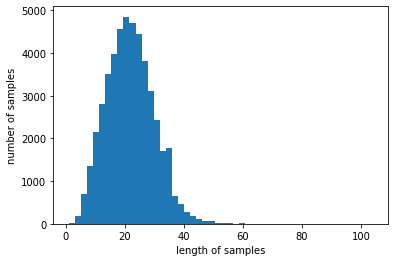

In [14]:
print('샘플의 최대 길이 :', max(len(l) for l in sentences))             # 샘플문장의 최대 길이
print('샘플의 평균 길이 :', sum(map(len, sentences)) / len(sentences))  # 샘플문장의 평균 길이

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
src_tokenizer = Tokenizer(oov_token='OOV')      # 모든 단어들을 사용하지만, 인덱스 1에는 단어 'OOV'를 할당함.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False)          # 태깅 정보들은 내부적으로 대문자 유지한채 저장.
tar_tokenizer.fit_on_texts(ner_tags)

In [16]:
vocab_size = len(src_tokenizer.index_word) + 1
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기 :', vocab_size)     # 단어 정보 집합의 크기
print('태그 집합의 크기 :', tag_size)       # 개체명 태깅 정보 집합의 크기

단어 집합의 크기 : 31819
태그 집합의 크기 : 18


In [17]:
print('단어 OOV의 인덱스 :', src_tokenizer.word_index['OOV'])

단어 OOV의 인덱스 : 1


In [18]:
x_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

print(sentences[0])     # 문장
print(x_data[0])        # 문장 sesquence
print()
print(ner_tags[0])      # 태그
print(y_data[0])        # 태그 sequence

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [19]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'     # 원래 index 0 에 해당하는 태그가 없으므로 추가해줌.

print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [20]:
# 문장 길이 맞추기
max_len = 70
x_data_pad = pad_sequences(x_data, padding='post', maxlen=max_len)
y_data_pad = pad_sequences(y_data, padding='post', maxlen=max_len)

In [21]:
# train, test data 나누기
x_train, x_test, y_train, y_test = train_test_split(x_data_pad, y_data_pad, test_size=.2, random_state=777)

In [22]:
# target data를 원핫인코딩하기 -> split이전에 이 시행을 해도 될듯
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [23]:
# 데이터 shape 확인
print('Train Input  :', x_train.shape)
print('Train Output :', y_train.shape)
print('Test  Input  :', x_test.shape)
print('Test  Output :', y_test.shape)

Train Input  : (38367, 70)
Train Output : (38367, 70, 18)
Test  Input  : (9592, 70)
Test  Output : (9592, 70, 18)


## F1-Score test

In [24]:
# 실제값
true = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O']

# 예측값
pred = ['O'] * len(true)

print(pred)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [25]:
# 정답 개수 세기
hit = 0
for t, p in zip(true, pred):
    if t==p:
        hit += 1

# 정확도(accuracy)
accuracy = hit / len(true)
print(f'정확도 : {100*accuracy:.2f}%')

정확도 : 78.26%


In [26]:
! pip install seqeval

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=092d128e36d72cddafc2b07dcc1d0d2a303207a52b6008775a6fbdf70d925573
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [27]:
# 정밀도(precision), 재현률(recall)
# 정밀도 = TP / (TP + FP) : 특정 개체라고 예측한 경우 중 예측이 일치한 비율
# 재현률 = TP / (TP + FN) : 특정 개체 중 정답을 맞춘 비율
# f1 score = 2 * (정밀도 * 재현률) / (정밀도 + 재현률)

In [28]:
from seqeval.metrics import classification_report

print(classification_report([true], [pred]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       0.00      0.00      0.00         2

   micro avg       0.00      0.00      0.00         3
   macro avg       0.00      0.00      0.00         3
weighted avg       0.00      0.00      0.00         3



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## F1-score를 측정하는 콜백 클래스

In [29]:
from tensorflow.keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

In [30]:
class F1score(Callback):
    
    def __init__(self, value=0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char
    
    def sequences_to_tags(self, sequences):
        result = []
        for sequence in sequences:
            tag = []
            for pred in sequence:                       # seq로부터 예측값을 하나씩 꺼냄
                pred_index = np.argmax(pred)            # [0 0 1 0 0]이라면 2를 반환
                tag.append(index_to_ner[pred_index].replace('PAD', 'O'))
            result.append(tag)
        return result

    def on_epoch_end(self, epoch, logs={}):
        '''
        에포크 끝날 때 마다 실행되는 함수
        '''
        # char Embedding 사용하는 경우
        if self.use_char:
            x_test = self.validation_data[0]
            x_char_test = self.validation_data[1]
            y_test = self.validation_data[2]
            y_predicted = self.model.predict([x_test, x_char_test])
        else:
            x_test = self.validation_data[0]
            y_test = self.validation_data[1]
            y_predicted = self.model.predict([x_test])
        
        pred_tags = self.sequences_to_tags(y_predicted)
        test_tags = self.sequences_to_tags(y_test)

        score = f1_score(pred_tags, test_tags)

        print(f' - f1: {100*score:04.2f}')
        print(classification_report(test_tags, pred_tags))

        # F1 score가 지금까지 중 가장 높은 경우
        if score > self.values:
            print(f'f1_score improved from {self.value} to {score}, saving model to best_model.h5')
            self.model.save('best_model.h5')
            self.value = score
        else:
            print(f'f1_score did not impove from {self.value}')


## 제목 미정

1. 문장의 첫번째 단어에는 I가 나오지 않습니다.
2. O-I 패턴은 나오지 않는다.
3. B-I-I 패턴에서 개체명은 일관성을 유지합니다.
    * ex : B-PER 다음에는 I-PER과 I-Org중 I-PER이 오는것이 맞다.

In [32]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

AttributeError: ignored

In [31]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

Using TensorFlow backend.


AttributeError: ignored

In [31]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)

AttributeError: ignored

In [33]:
import keras
keras.__version__

AttributeError: ignored

In [31]:
import keras
keras.__version__

'2.5.0'

# Transformer

## 기존의 seq2seq모델의 한계


* 입력시퀀스를 하나의 벡터표현으로 압축(context vector)
    * 디코더는 이를 통해 출력 시퀀스를 만들어냄
* 정보가 일부 손실된다는 단점

* $d_{model} = 512$
* num_layers = 6
* num_heads = 8
* $d_{ff} = 2048$

![](https://wikidocs.net/images/page/31379/transformer1.PNG)
![](https://wikidocs.net/images/page/31379/transformer2.PNG)
![](https://wikidocs.net/images/page/31379/transformer4_final_final_final.PNG)

## 포지셔널 인코딩

![](https://wikidocs.net/images/page/31379/transformer5_final_final.PNG)

![](https://wikidocs.net/images/page/31379/transformer6_final.PNG)

![](https://wikidocs.net/images/page/31379/transformer7.PNG)

- pos : 입력 문장에서의 임베딩 벡터의 위치 
- i : 임베딩 벡터 내의 차원의 인덱스를 의미  
(pos, 2i) -->사인함수, (pos, 2i+1) --> 코사인함수

## 코드실습

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스에는 cos함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
# 50x 128크기를 가지는 포지셔널인코딩 행렬을 시각화해서 어떤 형태를 가지는지 봅시다.
# 입력 문장의 단어가 50, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬

sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel('Depth')
plt.xlim((0,128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 어텐션

![](https://wikidocs.net/images/page/31379/attention.PNG)

- 인코더 셀프 어텐션 : Query = Key = value
- 디코더 마스크드 셀프 어텐션 : Query = Key = value
- 디코더의 인코더-디코더 어텐션 : Query (디코더 벡터)  
key = value (인코더 벡터)

![](https://wikidocs.net/images/page/31379/transformer_attention_overview.PNG)